# Autoenconders

### *Natalia Rodriguez, Anthony Vega*

Los Autoencoders son redes neuronales no supervisadas (no necesitan etiquetas para entrenar el modelo) que aprenden a comprimir y codificar datos para luego reconstruirlos a partir del código comprimido, de manera que queden lo más parecidos a los datos originales.
   
    
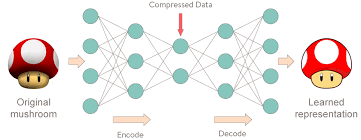
                
                                        Figura 1. Representación de autoencoder

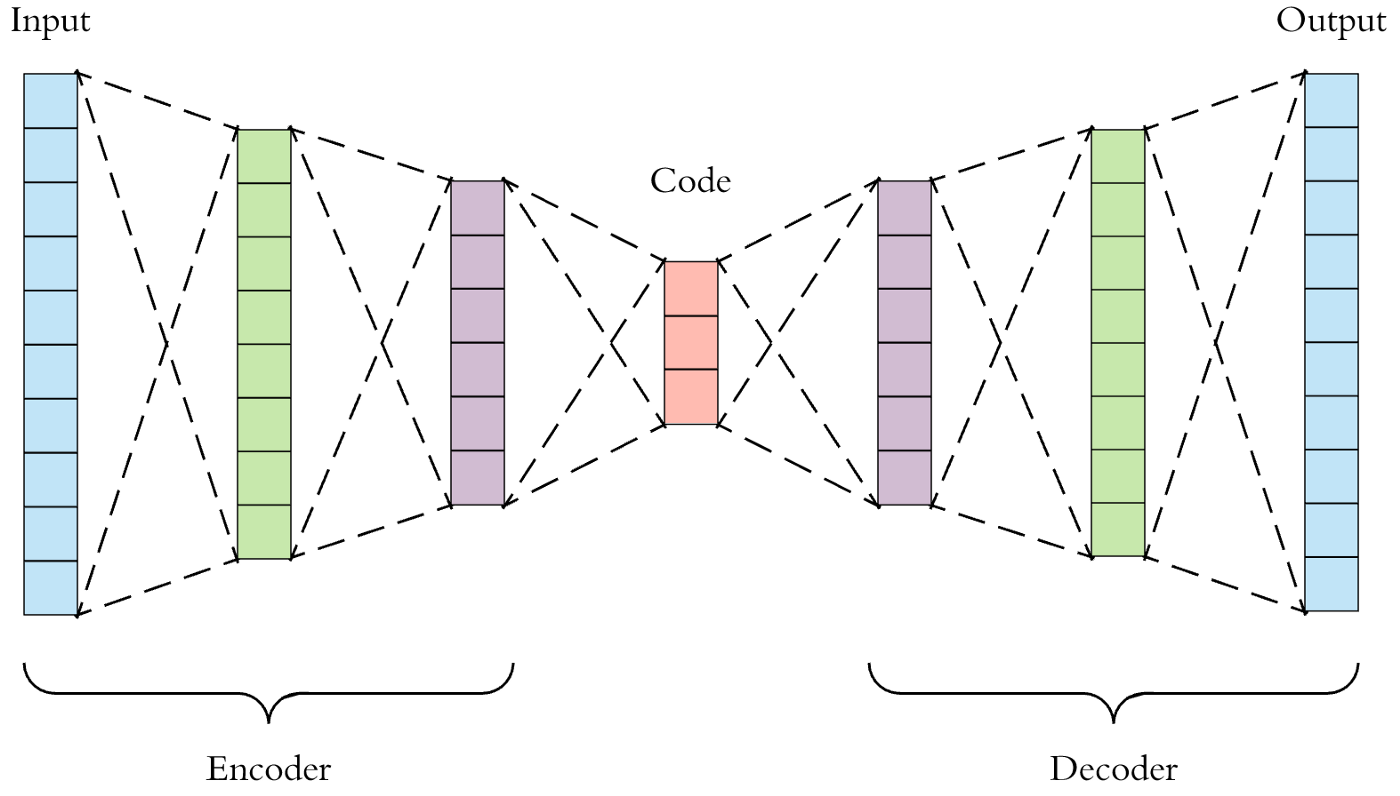

Los autoencoders son muy similares a otras técnicas para reducción de dimensionalidad como PCA (Principal Component Analysis), ambos generan una representación de los datos con menos dimensiones conservando solo las características de mayor importancia y removiendo las partes no esenciales. La diferencia radica en que PCA consigue este resultado usando transformaciones lineales, mientras que los autoencoders usan transformaciones no-lineales.


Autocodificación implica que las funciones de compresión/descompresión son:
 
 - Asociadas a datos particulares, es decir solo son capaces de comprimir datos similares a los usados para entrenamiento.
    
 - Con pérdidas, es decir que la salida con certeza va ser degradada en cierta medida.
    
 - De aprendizaje automático, es decir que son fáciles de adaptar a nuevas instancias con solo el entrenamiento adecuado.

Para prácticamente todos los contextos, el término autoencoder se utiliza siempre asociado a una red neuronal.


# Componentes de los autoencoders

### 1. Codificador #
   El modelo aprende a reducir las dimensiones de los datos de entrada y los comprime, tratando de mantener las características principales. Esta compresión se realiza generalmente con operaciones conocidas como "Downsample" o "Pooling"
### 2. Cuello de botella #
   Representa la capa que contiene los datos comprimidos. En esta etapa las dimensiones de los datos son las menores posibles, es decir se requiere una cantidad menor de bits para representar la información de entrada (el cuello de botella también es llamado punto de compresión máxima o espacio latente).
### 3. Decodificador #
   El modelo aprende a reconstruir los datos a partir de los datos codificados de manera que se parezcan lo máximo posible a los datos originales. Esta etapa por lo general presenta una simetría con la de codificación y las operaciones que se realizan son inversas a las de codificación. Por ejemplo, "downsample" ahora es "upsample" para conseguir la reconstrucción de la imagen con las dimensiones originales.
### 4. Reconstrucción de pérdidas #
   En esta etapa se mide qué tan bueno es el desempeño del decodificador y además qué tanto se parecen los datos de salida a los originales.

# Arquitectura de Autoencoders

   Dependiendo del caso se uso, la arquitectura de los autoencoders puede ser:
    
### 1. Red neuronal prealimentada (FeedForward)
   Las conexiones entre los componentes no forman un ciclo. La información se mueve en una sola dirección: Desde los nodos de entrada hasta los de salida.
    
### 2. Red neuronal LSTM
   Son un tipo especial de redes recurrentes, cuya característica principal es que la información puede persistir introduciendo bucles en el diagrama de la red.
 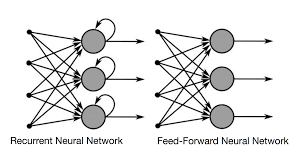
    
### 3. Red neuronal convolutiva
   Es un algoritmo que puede tomar una imagen de entrada, asignar importancia a varios aspectos u objetos de la imagen y tener la capacidad de diferenciar uno de la otro. La idea de este tipo de redes es reducir las imágenes a una forma más fácil de procesar, sin perder características críticas para lograr una buena predicción.

# Ventajas y desventajas de los Autoencoders

   Los autoencoders no son muy utilizados en problemas reales de compresión, actualmente es casi imposible poder entrenar un autoencoder para conseguir un desempeño tan bueno como los algoritmos de compresión típicos JPEG o MP3, conseguir un rendimiendo relativamente similar implicaría aplicar una cantidad considerable de restricciones al modelo que lo volverían poco práctico o útil para una cierta entrada muy específica.

Entonces, la utilidad práctica de los autoencoders no es la compresión, sino mas bien otros campos como eliminación de ruido y visualización ya que un autoencoder puede aprender proyecciones de datos mucho más complejas e interesantes que las técnicas básicas. Por ejemplo, para visualización de datos en 2D posiblemente el mejor algoritmo de la actualidad es t-SNE, pero este requiere datos de baja dimensionalidad, lo cual se puede conseguir con mucha eficiencia usando un autoencoder sobre los datos como etapa previa y luego mapear su representación comprimida para su visualización en un plano 2D.

# Algunas aplicaciones de Autoencoders

## 1. Detección de anomalías
   Se puede usar la medida del error de reconstruccion de pérdidas para detectar imágenes que no forman parte del set de datos. Un error pequeño indicaría que la imagen pertenece al set de datos, mientras que si se pasa una imagen que no pertenece al set de datos, se obtiene un error de valor muy alto que que la red falló al reconstruir la imagen.

## 2. Eliminación de ruido en imágenes ( denoising autoencoder)
   Se puede entrenar este  tipo de redes de manera que aprendan a remover el ruido de las señales, ya sean imágenes, audio o documentos. Esto es posible debido a que la naturaleza del autoencoder va considerar el ruido como una característica no esencial a la hora de codificar, por tanto, no estará presente en la reconstrucción que genere la red.

### Ejemplo utilizando dataset NotMNIST (Letras)

In [1]:
#Import required libraries

#Some of thye internal functions in tensorflow_backend has been replaced with updated version so they show some warnings
#the previous functions still work so we can just ignore the warnings 

import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
#This function will extract images packed in gzip files
#extract_data returns a vector of "num_images" of 28x28 pixels
#extract_labels returns a column vector with numbered classes

def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data
    
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [3]:
#Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [4]:
#Load 60k images for training and 10k for test

train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [5]:
#Labels are only needed for plotting but not for training the network

train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [6]:
#Verify the shapes of training and test sets

print("Training set (images) shape: {shape}".format(shape=train_data.shape))
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [7]:
#Reshape data to 4-dimensional vectors ===> (num imgs, rows, cols, chans)
#chans means the colors data series the images contain, 3 for RGB, 1 for grayscale

train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
#Normalize pixel values

train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [9]:
#Verify the maximun value is now 1

np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [10]:
#Separate the training data, use 20% of training samples to validate the model
#This reduces the change of overfitting because we perform validation with samples
#that haven't seen before while training the network

from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [11]:
#Add some gaussian noise (mean 0, deviation 1) to the input images
#Noise factor is our hyperparameter, set it to 0.5 as default

#Clipping data is a good practice when adding noise. It can generate negative numbers of values greater than 1
#clip would set them to 0 or 1 respectively

noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

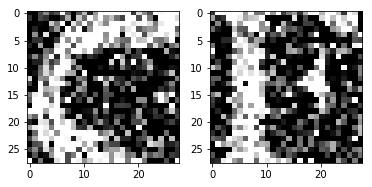

In [12]:
#Verify the noise was applied properly

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [13]:
#Define hyperparameters for training
#Epoch defines the number times that the learning algorithm will work through the entire training dataset.
#Batch size is the number of samples to be processes before updating model parameters.
#An epoch is comprised of one or more batches

batch_size = 128
epochs = 20

In [14]:
#Define the input layer, it takes input images of x*y pixels and inCHannel channels.

inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [15]:
#Create the hidden layers
#First conv will have 32 3x3 filters, rectified linear activation function and padding (output with same length)
#Second conv has now 64 filters, and 128 for the third one
#Each pooling will use 2x2 cores and extract the max value, so each pooling done reduce the input size by half.

#Decoder performs the reverse process.

def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded


In [16]:
#Create the model, arguments are the input layer and the stack of hidden layer
#Compile the model, specify the function to measure loss and the optimizer to minimize it

autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
#Train the model using the noisy images, the original images as ground truth and the training hyperparameters defined

autoencoder_train = autoencoder.fit(x_train_noisy,
                                    train_X, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_valid_noisy, valid_X))

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 49s 1ms/step - loss: 0.0523 - val_loss: 0.0273
Epoch 2/20
48000/48000 [==============================] - 49s 1ms/step - loss: 0.0241 - val_loss: 0.0206
Epoch 3/20
48000/48000 [==============================] - 52s 1ms/step - loss: 0.0206 - val_loss: 0.0189
Epoch 4/20
48000/48000 [==============================] - 51s 1ms/step - loss: 0.0189 - val_loss: 0.0181
Epoch 5/20
48000/48000 [==============================] - 49s 1ms/step - loss: 0.0178 - val_loss: 0.0173
Epoch 6/20
48000/48000 [==============================] - 51s 1ms/step - loss: 0.0170 - val_loss: 0.0166
Epoch 7/20
48000/48000 [==============================] - 52s 1ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 8/20
48000/48000 [==============================] - 51s 1ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 9/20
48000/48000 [==============================] - 50s 

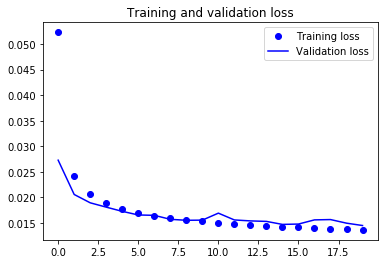

In [18]:
#Training process stores a log file so we can plot the loss vs epochs
#Can be seen how some overfitting happens at the very beggining, then as the process continues
#the training and validation losses remain closer so the model generalizes well

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
#Once the model is trained, we can feed it with test images and verify its predictions

pred = autoencoder.predict(x_test_noisy)

Test Images


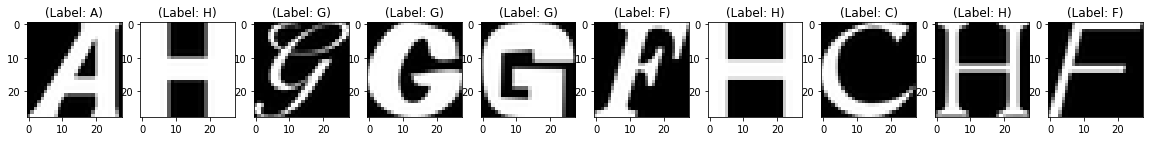

Test Images with Noise


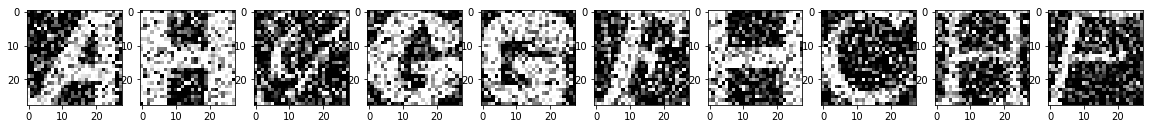

Reconstruction of Noisy Test Images


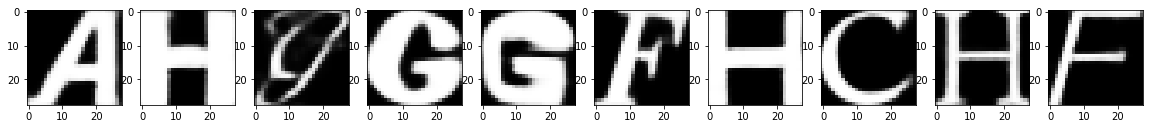

In [20]:
#Plot some of the original images with their noisy and reconstructed versions
#Can be seen that complex shapes as cursive letters represent a hardedr task for the autoencoder

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    

plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

###  Ejemplo usando dataset MNIST (digitos escritos a mano)

In [21]:
#Import, load, reshape and normalize the new dataset

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_x = x_train.reshape(60000, 784) / 255
val_x = x_test.reshape(10000, 784) / 255

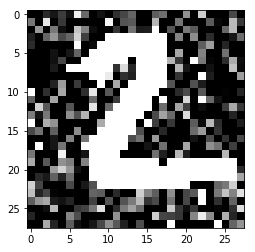

In [22]:
#Add some noise the same way we did before

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

plt.imshow(x_test_noisy[1].reshape(28, 28), cmap='gray')

In [23]:
#Dimensions of the input vector needs to match the input layer
#Since we are changing only the input data, we don't need to re-train the network

x_test_noisy = x_test_noisy.reshape(-1, 28,28, 1)
pred_dig = autoencoder.predict(x_test_noisy)

Test Images with Noise


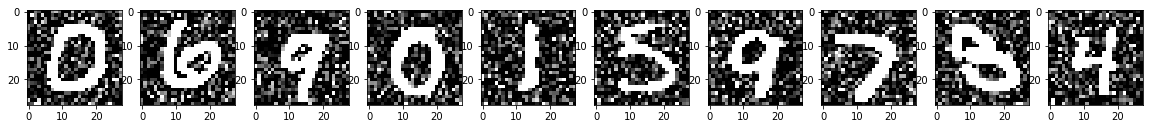

Reconstruction of Noisy Test Images


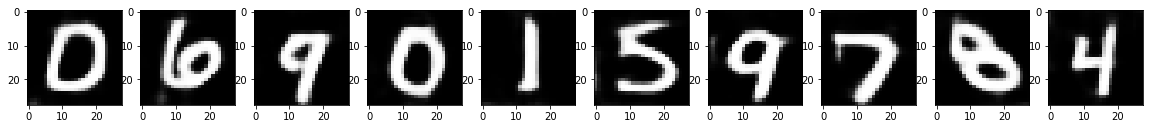

In [24]:
#Plot some of the inputs and the images reconstructed

plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred_dig[i, ..., 0], cmap='gray')  
plt.show()

## 3. Coloreo automático de imágenes en escala de grises ( colorizing autoencoder)

La conversión de RGB a escala de grises se realiza de forma trivial por medio de una fórmula que pondera los valores de cada componente de color en un pixel determinado. Sin emabrgo, el proceso inverso no es tan directo. Utilizando un autoencoder se puede lograr que la red establezca una relación basada en características propias de la imagen por medio de la cuál se puede estimar el color que corresponde, de este modo el proceso de coloreo se puede realizar de forma eficiente y automática. 

In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [26]:
#This function will be used to convert original pictures in dataset to grayscale

# convert from color image (RGB) to grayscale
# source: opencv.org
# grayscale = 0.299*red + 0.587*green + 0.114*blue
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [27]:
#load the CIFAR10 data, this dataset contain a collection of 32x32 color images of different classes

(x_train, _), (x_test, _) = cifar10.load_data()

# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [28]:
#create saved_images folder to store output colorized images 

imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

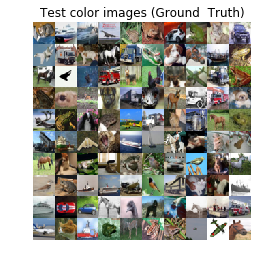

In [29]:
# display the 1st 100 input images (color and gray)

imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [30]:
# convert color train and test images to gray

x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

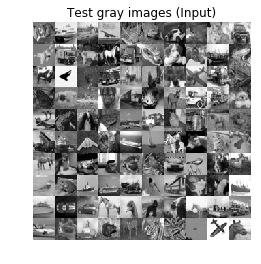

In [31]:
# display grayscale version of test images

imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [32]:
#normalize train and test color images

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [33]:
#normalize train and test grayscale images

x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [34]:
#reshape images to row x col x channel for CNN output/validation

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

In [35]:
#reshape images to row x col x channel for CNN input

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [36]:
# network hyperparameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256

# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [37]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [38]:
# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

In [39]:
# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [40]:
# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________________________


In [41]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [42]:
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

In [43]:
outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [44]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731      
Total para

In [45]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [46]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [47]:
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [48]:
# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [49]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [50]:
# called every epoch
callbacks = [lr_reducer, checkpoint]

In [51]:
# train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 203s 4ms/step - loss: 0.0157 - val_loss: 0.0117

Epoch 00001: val_loss improved from inf to 0.01169, saving model to /home/anthony/Downloads/saved_models/colorized_ae_model.001.h5
Epoch 2/30
50000/50000 [==============================] - 231s 5ms/step - loss: 0.0103 - val_loss: 0.0097

Epoch 00002: val_loss improved from 0.01169 to 0.00969, saving model to /home/anthony/Downloads/saved_models/colorized_ae_model.002.h5
Epoch 3/30
50000/50000 [==============================] - 220s 4ms/step - loss: 0.0093 - val_loss: 0.0090

Epoch 00003: val_loss improved from 0.00969 to 0.00900, saving model to /home/anthony/Downloads/saved_models/colorized_ae_model.003.h5
Epoch 4/30
50000/50000 [==============================] - 209s 4ms/step - loss: 0.0087 - val_loss: 0.0084

Epoch 00004: val_loss improved from 0.00900 to 0.00838, saving model to /home/anthony/Downloads/saved_models/colorized_ae

In [52]:
#If you have previously trained the network, you can load the weights from last best model by specifying the file name 

#autoencoder.load_weights('./saved_models/colorized_ae_model.016.h5')

In [53]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

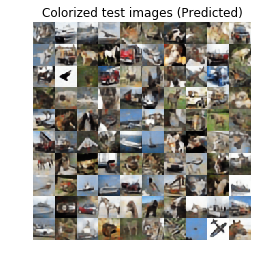

In [54]:
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized_single.png' % imgs_dir)
plt.show()

img_idx= 5614


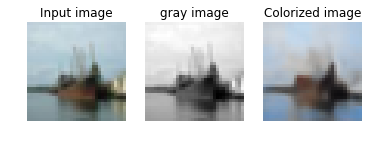

In [55]:
img_idx = np.random.randint(0, 10000)
print("img_idx=", img_idx)

plt.subplot(131)
plt.axis('off')
plt.title('Input image')
plt.imshow(x_test[img_idx:img_idx+1].reshape(32,32,3), interpolation='none')
plt.savefig('%s/gray_single.png' % imgs_dir)

plt.subplot(132)
plt.axis('off')
plt.title('gray image')
plt.imshow(x_test_gray[img_idx:img_idx+1].reshape(32, 32), interpolation='none', cmap='gray')
plt.savefig('%s/colorized_single.png' % imgs_dir)

plt.subplot(133)
plt.axis('off')
plt.title('Colorized image')
plt.imshow(x_decoded[img_idx:img_idx+1].reshape(32, 32, 3), interpolation='none', cmap='jet')
plt.savefig('%s/colorized_single.png' % imgs_dir)

# Más sobre autoencoders...

Algunos enlaces de interés para profundizar en la fundamentación matemática de los autoencoders:

https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases

http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/

Para explorar más desde una perspectiva de implementación, los ejemplos usados en esta notebook y algunos otros adicionales se pueden encontrar también en los siguientes enlaces:

https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial

https://blog.keras.io/building-autoencoders-in-keras.html

https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726